In [42]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler
import numpy as np

from warnings import filterwarnings
filterwarnings('ignore')


In [2]:
# Load the Titanic dataset
titanic_df = pd.read_csv('train.csv')

# Drop columns that are not useful for prediction
titanic_df = titanic_df.drop(['PassengerId', 'Name',  'Cabin'], axis=1)


In [3]:
# Handle missing values
titanic_df['Age'].fillna(titanic_df['Age'].median(), inplace=True)
titanic_df['Embarked'].fillna(titanic_df['Embarked'].mode()[0], inplace=True)



In [4]:
# Convert categorical variables to numerical
encoder = LabelEncoder()
titanic_df['Sex'] = encoder.fit_transform(titanic_df['Sex'])
titanic_df['Embarked'] = encoder.fit_transform(titanic_df['Embarked'])
titanic_df['Ticket'] = encoder.fit_transform(titanic_df['Ticket'])



In [5]:
# Define features and target variable
X = titanic_df.drop('Survived', axis=1)
y = titanic_df['Survived']



In [6]:
numeric_cols = X.select_dtypes(np.number).columns.to_list()

scaler = MinMaxScaler()

scaler.fit(X[numeric_cols])

X[numeric_cols] = scaler.transform(X[numeric_cols])

In [7]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



<Figure size 1200x600 with 0 Axes>

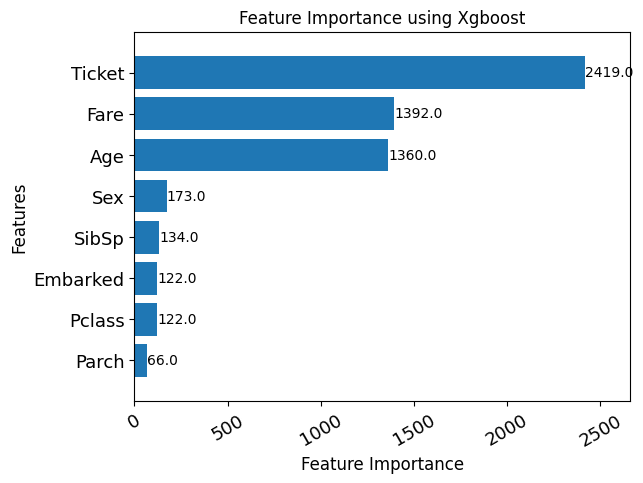

In [46]:
# Define XGBoost classifier
xgb_classifier = xgb.XGBClassifier(random_state=1, n_estimators=500)

# Train XGBoost classifier
xgb_classifier.fit(X_train, y_train)

# Plot relative importance of features
plt.figure(figsize=(12,6))
xgb.plot_importance(xgb_classifier, height=0.8, grid=False)
plt.xticks(fontsize=13, rotation=30)
plt.yticks(fontsize=13)
plt.xlabel('Feature Importance', fontsize=12)
plt.ylabel('Features', fontsize=12)
plt.title('Feature Importance using Xgboost', fontsize=12)
plt.savefig('xgboost.png')
plt.show()

In [47]:
importances = xgb_classifier.feature_importances_

In [49]:
xgb_classifier.feature_names_in_

array(['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare',
       'Embarked'], dtype='<U8')

In [50]:
nums = []
thresholds = []
accuracies = []
for i in range(len(importances)):
    selected_feats = SelectFromModel(xgb_classifier, threshold=importances[i], prefit=True)
    transformed_X = selected_feats.transform(X_train)
    model = RandomForestClassifier(random_state=42).fit(transformed_X, y_train)
    transformed_X_test = selected_feats.transform(X_test)
    accuracy = accuracy_score(y_test, model.predict(transformed_X_test))
    print(f"threshold value = {(importances[i]): <15}; no. featues = {transformed_X.shape[1]}; accuracy = {accuracy}")
    nums.append(transformed_X.shape[1])
    thresholds.append(importances[i])
    accuracies.append(accuracy)
    


threshold value = 0.23350946605205536; no. featues = 2; accuracy = 0.7653631284916201
threshold value = 0.4995066523551941; no. featues = 1; accuracy = 0.7821229050279329
threshold value = 0.039809346199035645; no. featues = 5; accuracy = 0.8044692737430168
threshold value = 0.08574948459863663; no. featues = 3; accuracy = 0.7821229050279329
threshold value = 0.03457436338067055; no. featues = 7; accuracy = 0.8212290502793296
threshold value = 0.027455748990178108; no. featues = 8; accuracy = 0.8268156424581006
threshold value = 0.04098500683903694; no. featues = 4; accuracy = 0.7988826815642458
threshold value = 0.038409966975450516; no. featues = 6; accuracy = 0.8379888268156425


In [51]:
optimal_threshold = thresholds[np.argmax(accuracies)]
optimal_num_of_feats = nums[np.argmax(accuracies)]
print(f"Best accuracy: {np.max(accuracies)};\noptimal number of features: {optimal_num_of_feats};\nOptimal threshold: {optimal_threshold}")

Best accuracy: 0.8379888268156425;
optimal number of features: 6;
Optimal threshold: 0.038409966975450516


In [55]:
optimal_selects = SelectFromModel(xgb_classifier, threshold=optimal_threshold, prefit=True)
act_model = RandomForestClassifier(random_state=42).fit(optimal_selects.transform(X_train), y_train)
feats_index = optimal_selects.get_support()
selected_cols = X_train.columns[feats_index]
print(f"Selected features: {selected_cols}")

Selected features: Index(['Pclass', 'Sex', 'Age', 'SibSp', 'Fare', 'Embarked'], dtype='object')


Predicting the accuracy of the model on the training set

In [56]:
accuracy_score(y_train, act_model.predict(optimal_selects.transform(X_train)))

0.9775280898876404

Predicting the accuracy of the model on the test set

In [57]:
accuracy_score(y_test, act_model.predict(optimal_selects.transform(X_test)))

0.8379888268156425

In [58]:
act_model.predict_proba(optimal_selects.transform(X_test))

array([[0.87      , 0.13      ],
       [0.95      , 0.05      ],
       [0.89833333, 0.10166667],
       [0.02      , 0.98      ],
       [0.52      , 0.48      ],
       [0.08      , 0.92      ],
       [0.27206616, 0.72793384],
       [0.93      , 0.07      ],
       [0.254     , 0.746     ],
       [0.03      , 0.97      ],
       [0.3       , 0.7       ],
       [0.91      , 0.09      ],
       [0.95      , 0.05      ],
       [0.9       , 0.1       ],
       [0.80938095, 0.19061905],
       [0.02      , 0.98      ],
       [0.66      , 0.34      ],
       [0.05794048, 0.94205952],
       [0.84      , 0.16      ],
       [0.98      , 0.02      ],
       [1.        , 0.        ],
       [0.49766667, 0.50233333],
       [0.82      , 0.18      ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [0.9       , 0.1       ],
       [0.93333333, 0.06666667],
       [0.93      , 0.07      ],
       [0.8       , 0.2       ],
       [0.52      , 0.48      ],
       [0.